In [50]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [61]:
# Load CIFAR10
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=ToTensor())
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
classes = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])
torch.Size([32, 32, 3])
Label: ship


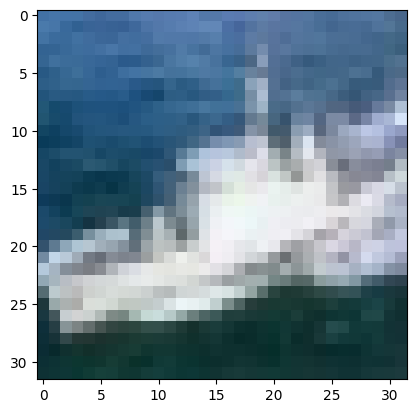

In [36]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# plt.imshow() expects (32, 32, 3)
img = train_features[0].squeeze().swapaxes(0,1).swapaxes(1,2)
label = train_labels[0]
print(img.size())
print(f"Label: {classes[label]}")
plt.imshow(img, cmap="gray")
plt.show()


In [72]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        block = BasicBlock
        num_blocks=[1, 1, 1, 1]
        # Normally, we have 2 blocks per layer.
        # but we need to reduce the # of trainable parameter to <= 5mil...
        # num_blocks=[2, 2, 2, 2]
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [73]:
model = ResNet18(num_classes=len(classes)).to(device)
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(n_params)
print(n_params <= 5000000)

4903242
True


In [74]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03,
                      momentum=0.9, weight_decay=5e-4)



In [77]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(iterator):
        print(f"Training Batch Index: {batch_idx}")
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)    

        outputs = model(inputs)
        
        
        loss = criterion(outputs, targets)
        
        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
        
        loss.backward()
        optimizer.step()
            
    return epoch_loss / len(iterator), correct / total

In [78]:
def test(model, iterator, criterion):
    
    # Q3c. Set up the evaluation function.
    epoch_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(iterator):
            print(f"Evaluating Batch Index: {batch_idx}")
            inputs = inputs.to(device)
            targets = targets.to(device)    
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
            
        
    return epoch_loss / len(iterator), correct / total

In [79]:
train_loss, train_acc = train(model, trainloader, optimizer, criterion)
print(train_loss)
print(train_acc)

Training Batch Index: 0
Training Batch Index: 1
Training Batch Index: 2
Training Batch Index: 3
Training Batch Index: 4
Training Batch Index: 5
Training Batch Index: 6
Training Batch Index: 7
Training Batch Index: 8
Training Batch Index: 9
Training Batch Index: 10
Training Batch Index: 11
Training Batch Index: 12
Training Batch Index: 13
Training Batch Index: 14
Training Batch Index: 15
Training Batch Index: 16
Training Batch Index: 17
Training Batch Index: 18
Training Batch Index: 19
Training Batch Index: 20
Training Batch Index: 21
Training Batch Index: 22
Training Batch Index: 23
Training Batch Index: 24
Training Batch Index: 25
Training Batch Index: 26
Training Batch Index: 27
Training Batch Index: 28
Training Batch Index: 29
Training Batch Index: 30
Training Batch Index: 31
Training Batch Index: 32
Training Batch Index: 33
Training Batch Index: 34
Training Batch Index: 35
Training Batch Index: 36
Training Batch Index: 37
Training Batch Index: 38
Training Batch Index: 39
Training B

In [81]:
test_loss, test_acc = test(model, testloader, criterion)
print(test_loss)
print(test_acc)

Evaluating Batch Index: 0
Evaluating Batch Index: 1
Evaluating Batch Index: 2
Evaluating Batch Index: 3
Evaluating Batch Index: 4
Evaluating Batch Index: 5
Evaluating Batch Index: 6
Evaluating Batch Index: 7
Evaluating Batch Index: 8
Evaluating Batch Index: 9
Evaluating Batch Index: 10
Evaluating Batch Index: 11
Evaluating Batch Index: 12
Evaluating Batch Index: 13
Evaluating Batch Index: 14
Evaluating Batch Index: 15
Evaluating Batch Index: 16
Evaluating Batch Index: 17
Evaluating Batch Index: 18
Evaluating Batch Index: 19
Evaluating Batch Index: 20
Evaluating Batch Index: 21
Evaluating Batch Index: 22
Evaluating Batch Index: 23
Evaluating Batch Index: 24
Evaluating Batch Index: 25
Evaluating Batch Index: 26
Evaluating Batch Index: 27
Evaluating Batch Index: 28
Evaluating Batch Index: 29
Evaluating Batch Index: 30
Evaluating Batch Index: 31
Evaluating Batch Index: 32
Evaluating Batch Index: 33
Evaluating Batch Index: 34
Evaluating Batch Index: 35
Evaluating Batch Index: 36
Evaluating 